# Air Quality Data Analysis Project


Air pollution has become a major environmental concern, especially in large cities. The Air Quality Index (AQI) is a composite measure that reflects the overall level of air contamination and its potential impact on human health. 

This project focuses on exploring, visualizing, and modeling AQI data to uncover trends, identify relationships between pollutants, and build a predictive model capable of estimating air quality based on measurable environmental factors.

Throughout this notebook, several steps are performed:
- **Data Exploration (EDA):** examining the dataset structure, distributions, correlations, and temporal trends.
- **Data Cleaning:** handling missing values, outliers, and temporal interpolation.
- **Modeling:** training machine learning models (such as XGBoost) to predict AQI levels.
- **Evaluation and Interpretation:** assessing model performance and interpreting feature importance.

The analysis provides both statistical insights and practical interpretations of how pollutant levels contribute to air quality fluctuations.


# First look of the data

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename), sep=',')

print(f">>> Input data found:")
print(df.describe(), "\n")
print(df.info(), "\n")

>>> Input data found:
                lon           lat           aqi            co            no  \
count  4.222400e+04  4.222400e+04  42224.000000  42224.000000  42224.000000   
mean   1.066953e+02  1.078280e+01      3.431627   1439.267843     22.141525   
std    1.045789e-10  9.517833e-12      1.373714   1465.344701     36.955377   
min    1.066953e+02  1.078280e+01      1.000000     93.930000      0.000000   
25%    1.066953e+02  1.078280e+01      2.000000    620.840000      0.860000   
50%    1.066953e+02  1.078280e+01      4.000000    947.950000      5.760000   
75%    1.066953e+02  1.078280e+01      5.000000   1668.930000     28.390000   
max    1.066953e+02  1.078280e+01      5.000000  18585.210000    393.390000   

                no2            o3           so2         pm2_5          pm10  \
count  42224.000000  42224.000000  42224.000000  42224.000000  42224.000000   
mean      35.615440     26.244224     41.349962     62.622832     75.803752   
std       73.035779     64.40

# Exploratory Data Analysis (EDA)

The EDA phase aims to gain an initial understanding of the dataset before modeling.  
Key goals include:
- Detecting missing or abnormal values in pollutant measurements.  
- Understanding the statistical distribution of AQI and pollutants.  
- Exploring correlations between variables.  
- Identifying temporal trends (daily, monthly, and seasonal patterns).  

Visual and numerical exploration helps determine whether certain pollutants or weather indicators strongly influence AQI, and whether time-dependent variations exist.

In [2]:
columns_to_drop = ['lon','lat']

df_fix = df.drop(columns=columns_to_drop, axis=1)

df_fix['dt'] = pd.to_datetime(df_fix['dt'])
df_fix.set_index('dt', inplace=True)
df_fix.sort_index(inplace=True)
print(df_fix.index.tz)

df_fix.index = df_fix.index.tz_localize('Etc/GMT+5').tz_convert('Asia/Ho_Chi_Minh')
print(df_fix.index.tz)

df_fix.replace([np.inf, 0.0, -9999.0, 9999.0, -np.inf], np.nan, inplace=True)
df_fix.interpolate(method='time', limit_direction='both', inplace=True)

print(df_fix.describe(), "\n")

None
Asia/Ho_Chi_Minh
                aqi            co            no           no2            o3  \
count  42224.000000  42224.000000  42224.000000  42224.000000  42224.000000   
mean       3.431627   1439.267843     22.147863     36.090071     26.530773   
std        1.373714   1465.344701     36.951728     23.757213     42.013429   
min        1.000000     93.930000      0.010000      0.580000      0.010000   
25%        2.000000    620.840000      0.870000     21.420000      0.260000   
50%        4.000000    947.950000      5.760000     31.530000      8.400000   
75%        5.000000   1668.930000     28.390000     44.550000     35.205000   
max        5.000000  18585.210000    393.390000    265.960000    446.320000   

                so2         pm2_5          pm10           nh3  
count  42224.000000  42224.000000  42224.000000  42224.000000  
mean      41.349962     62.623791     76.042357     10.664307  
std       30.270263     77.743959     88.124273      9.660609  
min       

In [3]:
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

def plotWithAQI(df):
    plt.figure(figsize=(15, 7))
    sns.pairplot(df, hue='aqi')    
    plt.show()

#plotWithAQI(df_fix)

COMMENT:

* some invalid
* some outliers

                aqi            co            no           no2            o3  \
count  42224.000000  42224.000000  42224.000000  42224.000000  42224.000000   
mean       3.431627   1439.245076     22.147397     36.086272     26.528808   
std        1.373714   1465.085745     36.947172     23.733268     41.995731   
min        1.000000     93.930000      0.010000      0.580000      0.010000   
25%        2.000000    620.840000      0.870000     21.420000      0.260000   
50%        4.000000    947.950000      5.760000     31.530000      8.400000   
75%        5.000000   1668.930000     28.390000     44.550000     35.205000   
max        5.000000  18157.960000    375.510000    230.310000    423.430000   

                so2        pm2_5          pm10           nh3  
count  42224.000000  42224.00000  42224.000000  42224.000000  
mean      41.349104     62.62245     76.040972     10.663827  
std       30.264270     77.72938     88.109671      9.652378  
min        0.300000      0.74000    

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x700 with 0 Axes>

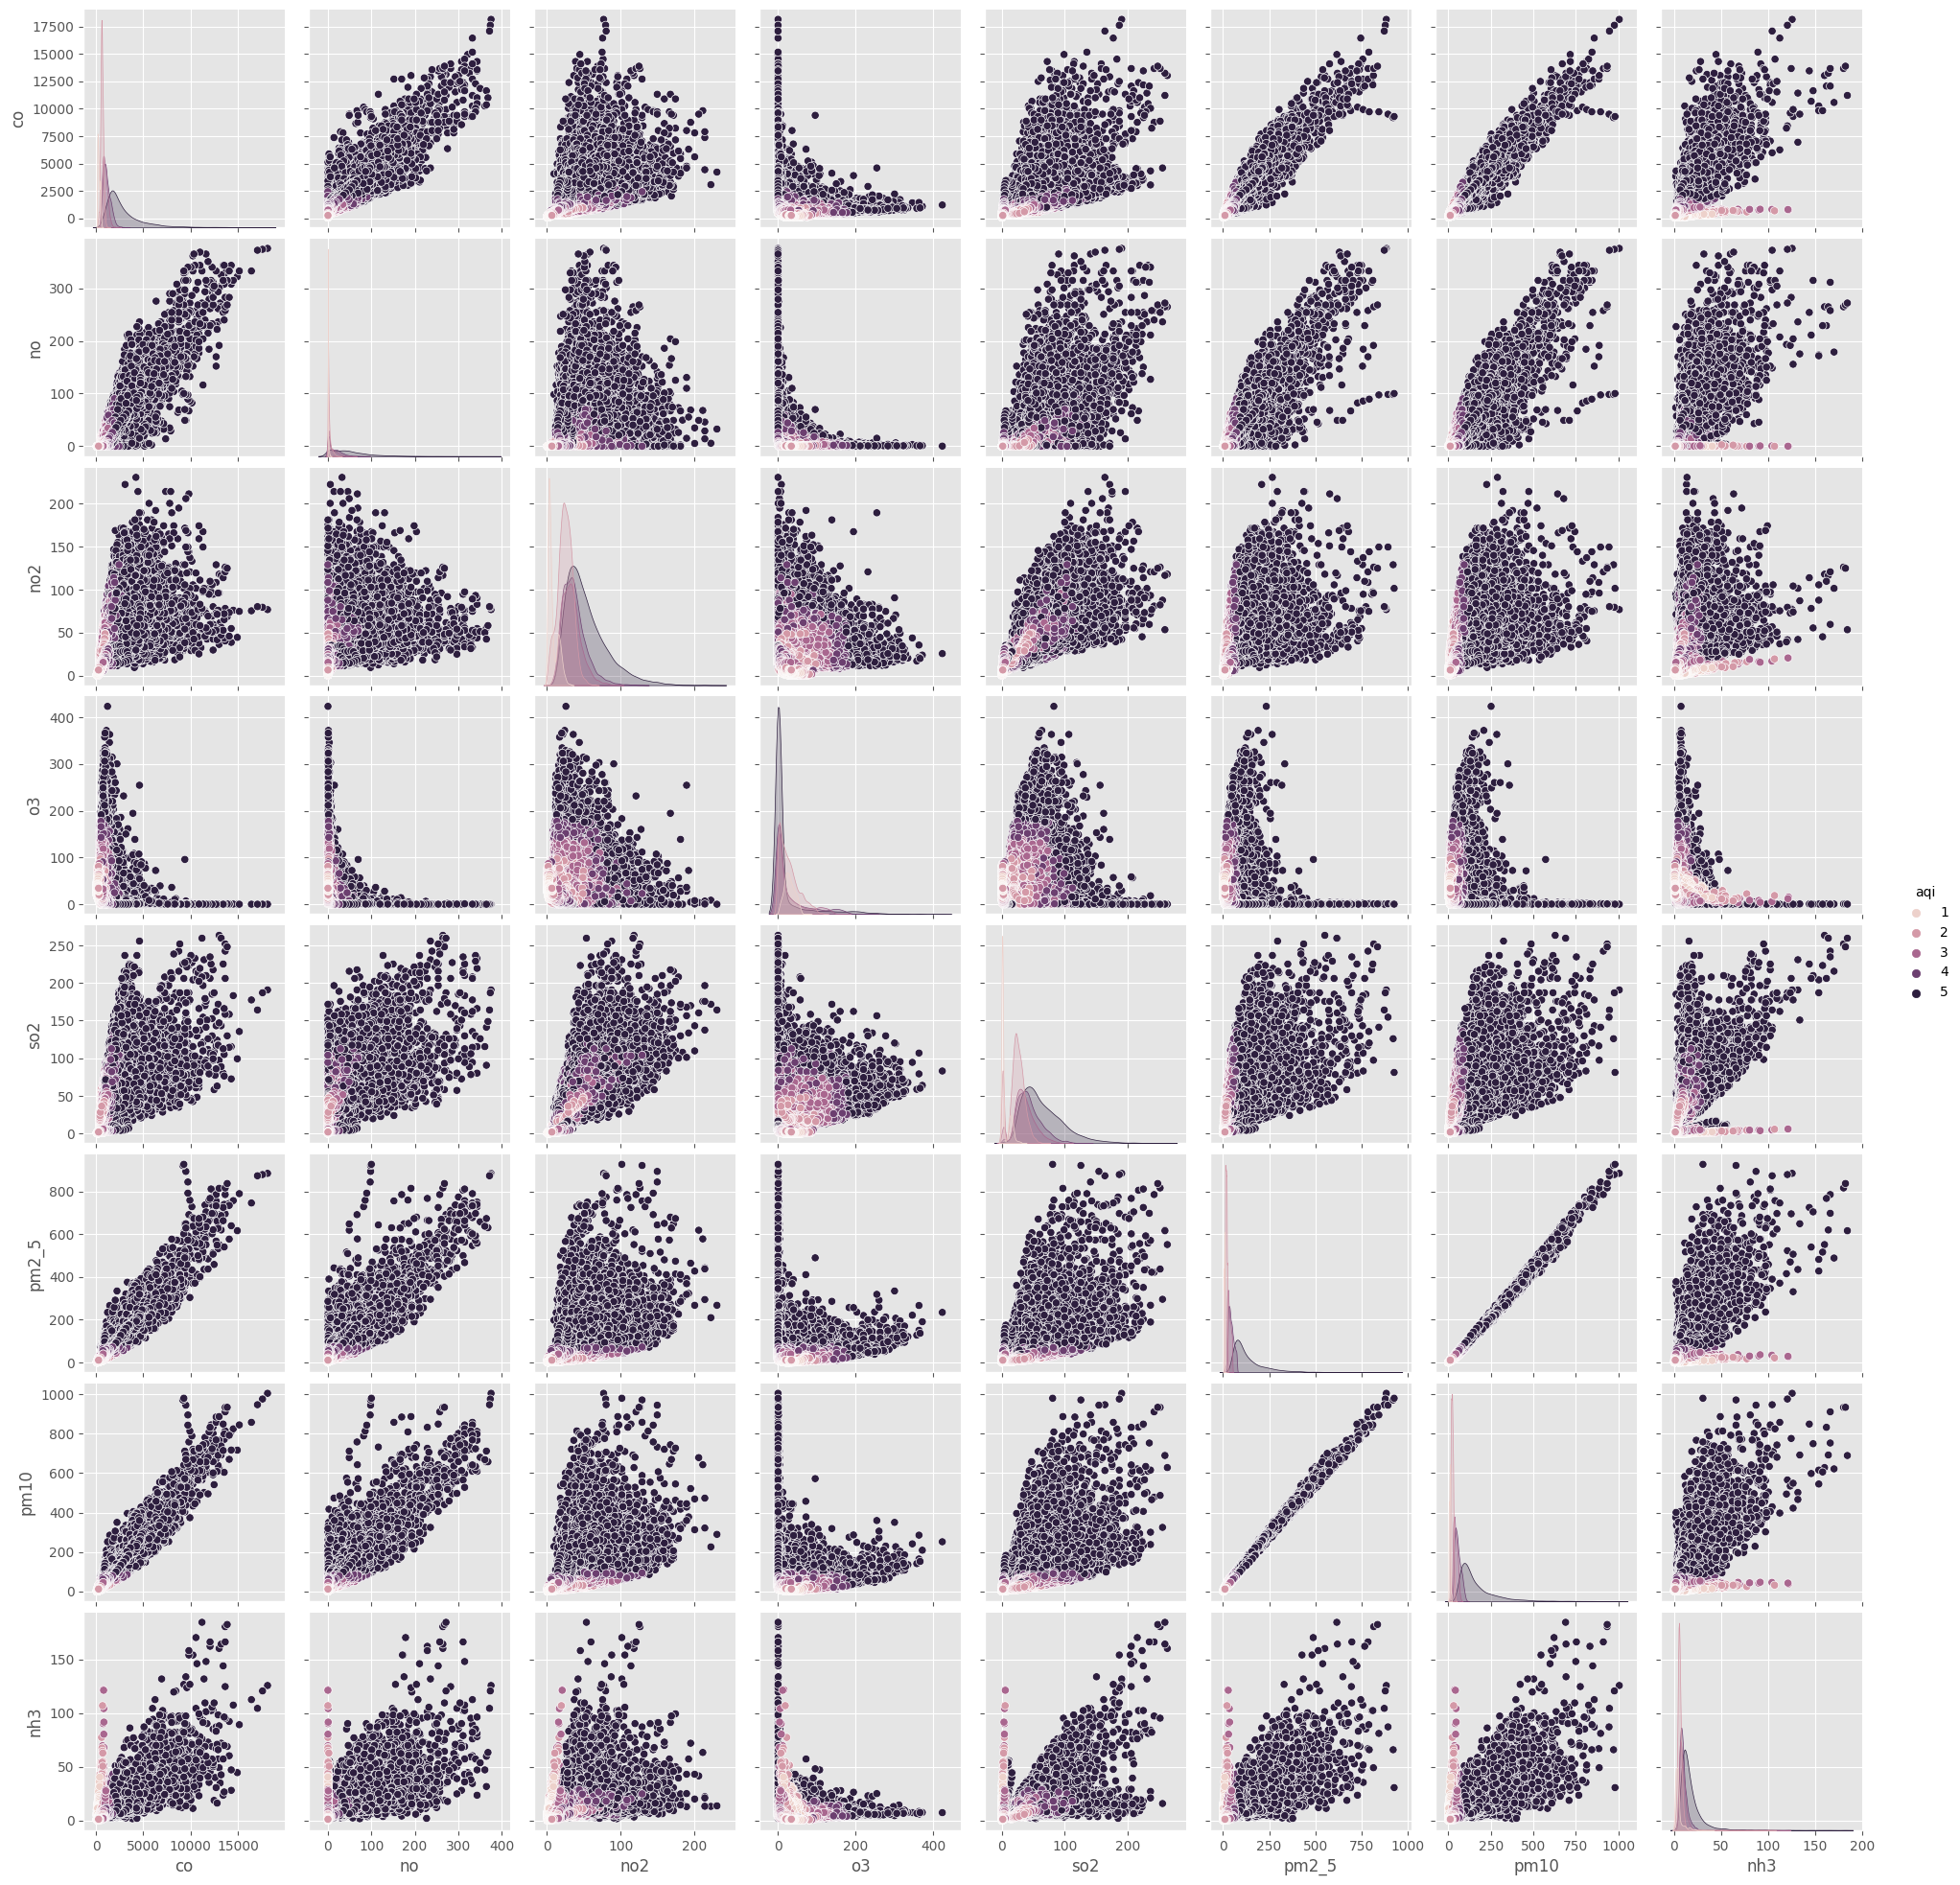

In [4]:
params = ['co', 'no2', 'pm2_5', 'pm10', 'o3', 'so2', 'nh3', 'no']

def simulate_outliers_iqr(df, column_name):

    upper_bound = df[column_name].max() * 0.9999
    
    capped_column = np.where(
        df[column_name] > upper_bound, 
        0,
        df[column_name]
    )

    return capped_column

df_capped = df_fix.copy()
for param in params:
    df_capped[param] = simulate_outliers_iqr(df_capped, param)

df_capped.replace([0.0, 0], np.nan, inplace=True)
df_capped.interpolate(method='time', limit_direction='both', inplace=True)

print(df_capped.describe(), "\n")
plotWithAQI(df_capped)

# Time-series specific EDA

In [5]:
df_capped['hour'] = df_capped.index.hour
df_capped['dayofweek'] = df_capped.index.dayofweek
df_capped['month'] = df_capped.index.month

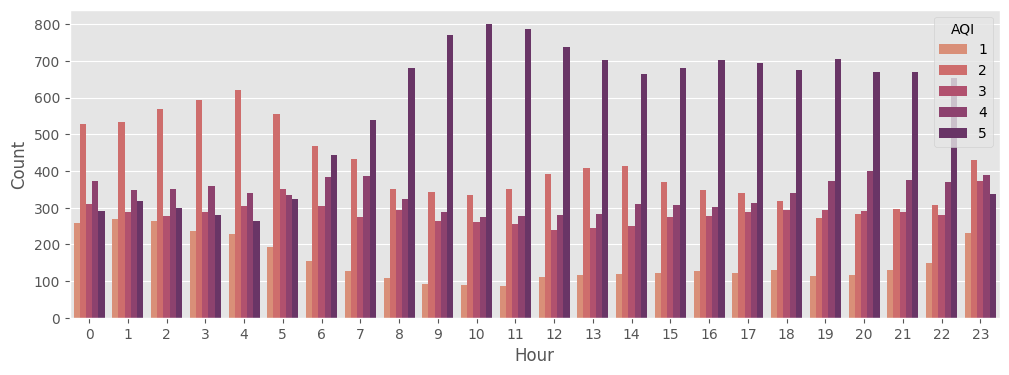

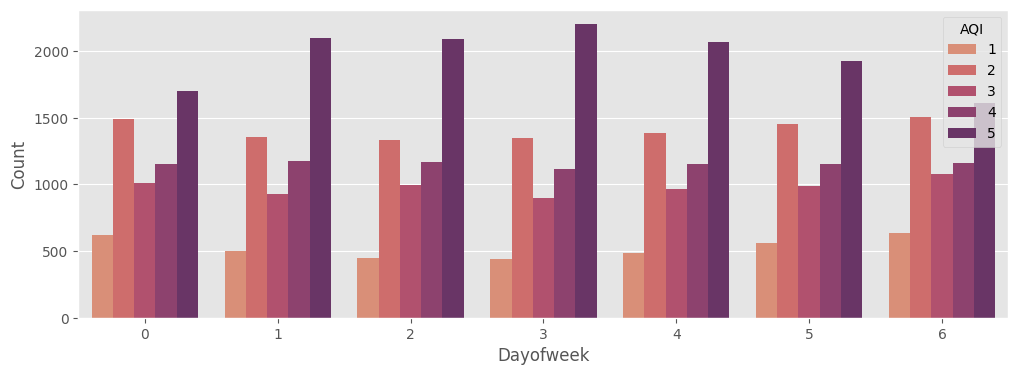

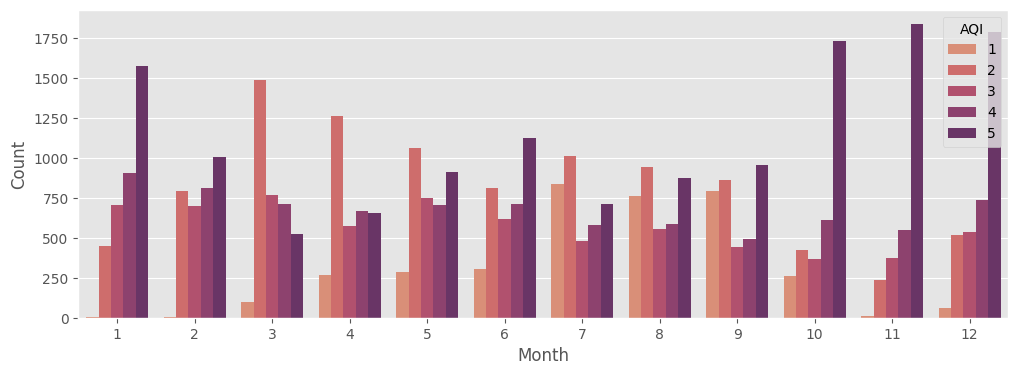

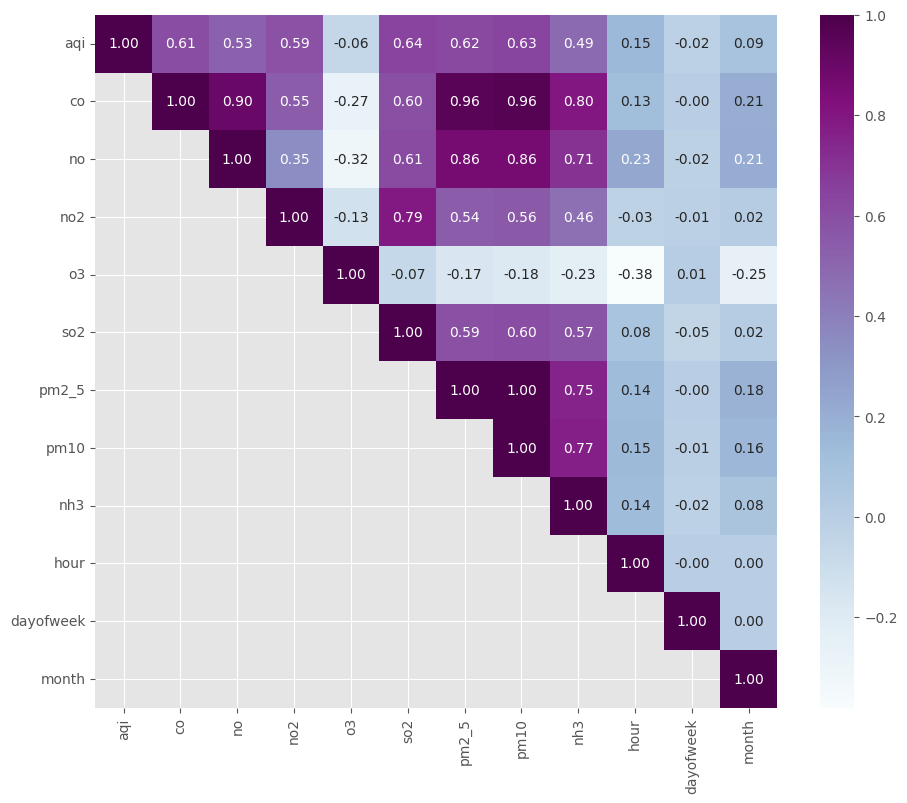

In [6]:
time_features = ['hour', 'dayofweek', 'month']

for feature in time_features:
    plt.figure(figsize=(12, 4))
    
    sns.countplot(
        data=df_capped, 
        x=feature,
        hue='aqi',
        palette="flare" 
    )
    
    plt.xlabel(feature.capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='AQI')
    plt.show()

corr_matrix = df_capped.corr()
triangle_mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix, 
    mask=triangle_mask,
    annot=True,
    fmt=".2f",
    cmap='BuPu'
)
plt.show()

From the visualizations and statistical exploration:

- **Distribution:** The AQI distribution is slightly right-skewed, indicating that most days have bad air quality. It could be a challenge for predicting model.
- **Correlation:** Several pollutants (such as PM2.5 and PM10) show strong positive correlation with AQI, while some gaseous pollutants (like O₃) may behave inversely depending on meteorological conditions.  
- **Temporal Trends:**  
  - The monthly AQI plot reveals potential **seasonal variation**, where pollution tends to peak in specific months.
  - The hourly pattern suggests **daily cycles**, possibly linked to traffic or industrial activity peaking in the morning and evening hours.  

These findings highlight the importance of incorporating temporal and multi-feature interactions when building predictive models.


# Feature Engineering

In [7]:
df_capped['hour_sin'] = np.sin(2 * np.pi * df_capped['hour'] / 24)
df_capped['hour_cos'] = np.cos(2 * np.pi * df_capped['hour'] / 24)
df_capped['dayofweek_sin'] = np.sin(2 * np.pi * df_capped['dayofweek'] / 7)
df_capped['dayofweek_cos'] = np.cos(2 * np.pi * df_capped['dayofweek'] / 7)
df_capped['month_sin'] = np.sin(2 * np.pi * df_capped['month']/12)
df_capped['month_cos'] = np.cos(2 * np.pi * df_capped['month']/12)

In [8]:
def create_advanced_features(df, pollutants):
    features_list = []
    
    lags = [1, 2, 4, 8, 12, 24]
    windows = [3, 6, 9, 12, 24]

    for col in pollutants:
        for lag in lags:
            lag_series = df[col].shift(lag)
            lag_series.name = f'{col}_lag_{lag}h'
            features_list.append(lag_series)
        
        for window in windows:
            roll_mean_series = df[col].rolling(window=window).mean()
            roll_mean_series.name = f'{col}_roll_mean_{window}h'
            features_list.append(roll_mean_series)
            
            roll_std_series = df[col].rolling(window=window).std()
            roll_std_series.name = f'{col}_roll_std_{window}h'
            features_list.append(roll_std_series)

        diff_series = df[col] - df[col].shift(1)
        diff_series.name = f'{col}_diff_over_1hour'
        features_list.append(diff_series)

    
    ratio_series = df['pm2_5'] / df['pm10']
    ratio_series.name = 'pm_ratio'
    features_list.append(ratio_series)
    
    ratio_series = df['no2'] / df['no']
    ratio_series.name = 'nitro_oxide_ratio'
    features_list.append(ratio_series)
    
    ratio_series = df['co'] * df['no']
    ratio_series.name = 'co_no_product'
    features_list.append(ratio_series)
        
    df_feat = pd.concat([df] + features_list, axis=1)
        
    return df_feat
    
mjr_params = ['co', 'no2', 'pm2_5', 'pm10', 'o3', 'no']

df_featured = create_advanced_features(df_capped, mjr_params)
df_featured = df_featured.dropna()

# Model training

After completing exploratory data analysis and data preprocessing, this section focuses on building machine learning models to predict the Air Quality Index (AQI) category or value.

The modeling workflow includes:
1. **Feature Preparation:** Selecting relevant pollutant and meteorological features.  
2. **Data Splitting:** Dividing the dataset into training and testing subsets.  
3. **Model Training:** Using XGBoost as the main predictive model, with Logistic Regression as a baseline.  
4. **Evaluation:** Assessing accuracy, F1-score, and confusion matrix to understand model performance.  
5. **Interpretation:** Analyzing feature importance to identify which variables most strongly influence AQI.

In [9]:
aqi_labels_map = {
    0: 'Good',
    1: 'Moderate',
    2: 'Unhealthy',
    3: 'VeryUnhealthy',
    4: 'Hazardous' 
}
label_names = [aqi_labels_map[i] for i in range(len(aqi_labels_map))]

In [10]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_featured['aqi'] = df_featured['aqi'].shift(-2)
df_featured.dropna(inplace=True)

y_numeric = df_featured['aqi'] - df_featured['aqi'].min()
y_label = y_numeric.map(aqi_labels_map)

X = df_featured.drop(columns=['aqi'])

split_point = int(len(df_featured) * 0.7)

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y_numeric[:split_point], y_numeric[split_point:]
y_train_label, y_test_label = y_label[:split_point], y_label[split_point:]

print(f"Size of train set: {X_train.shape},  {y_train.shape}")
print(f"Size of test set: {X_test.shape},  {y_test.shape}")

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
model = xgb.XGBClassifier(
    objective='multi:softmax',
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train,
          y_train,
          sample_weight=sample_weights)

Size of train set: (29538, 122),  (29538,)
Size of test set: (12660, 122),  (12660,)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

# Model brief evaluation
desc

Accuracy: 0.70703002

Classification report:
                precision    recall  f1-score   support

         Good       0.91      0.86      0.89      2908
     Moderate       0.80      0.71      0.75      3339
    Unhealthy       0.57      0.42      0.48      2282
VeryUnhealthy       0.27      0.34      0.30      1342
    Hazardous       0.74      0.96      0.83      2789

     accuracy                           0.71     12660
    macro avg       0.66      0.66      0.65     12660
 weighted avg       0.71      0.71      0.70     12660



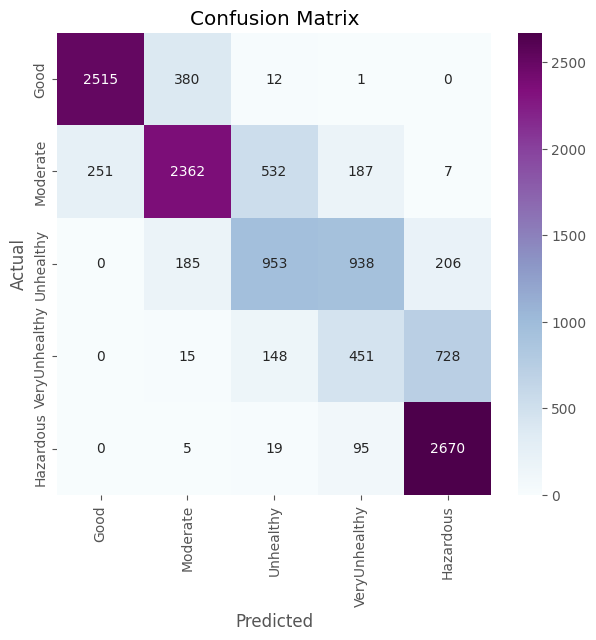

In [11]:
y_predictions_numeric = model.predict(X_test)
y_predictions_label = pd.Series(y_predictions_numeric).map(aqi_labels_map)

accuracy = accuracy_score(y_test, y_predictions_numeric)
print(f"Accuracy: {accuracy:.8f}")

report = classification_report(
    #y_test_label,
    y_test,
    #y_predictions_label,
    y_predictions_numeric,
    target_names=label_names)

print("\nClassification report:\n", report)


#cm = confusion_matrix(y_test_label, y_predictions_label)
cm = confusion_matrix(y_test, y_predictions_numeric)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='BuPu',
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

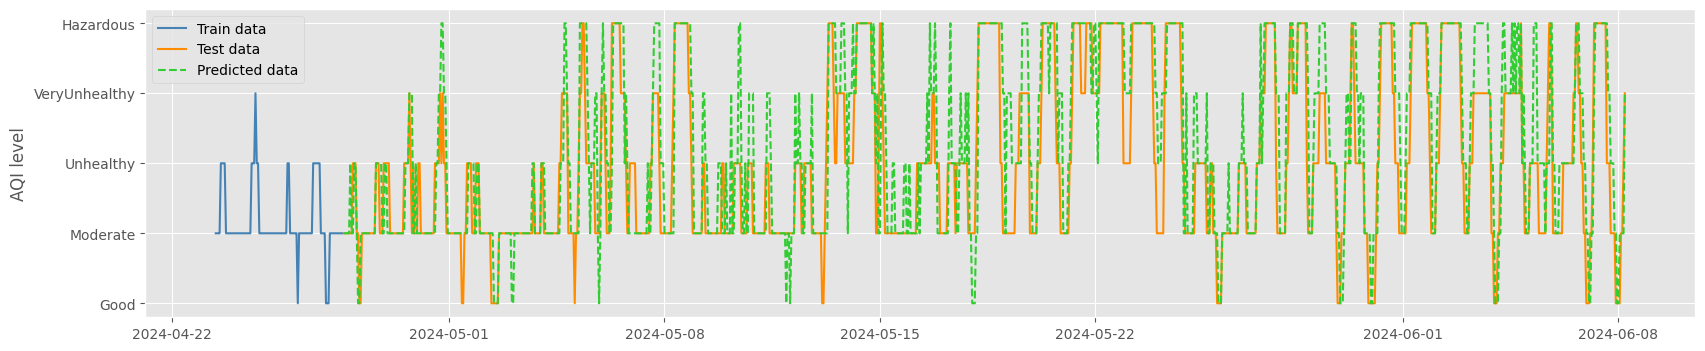

In [12]:
predictions_series = pd.Series(y_predictions_numeric, index=y_test.index)
predictions_series.name = 'Predicted'

plt.figure(figsize=(20, 4))

y_train_shortened = y_train.tail(100)
plt.plot(y_train_shortened.index, y_train_shortened, label='Train data', color='steelblue')

y_test_shortened = y_test.head(1000)
plt.plot(y_test_shortened.index, y_test_shortened, label='Test data', color='darkorange')

predictions_series_shortened = predictions_series.head(1000)
plt.plot(predictions_series_shortened.index, predictions_series_shortened, label='Predicted data', color='limegreen', linestyle='--')

plt.ylabel('AQI level', fontsize=12)
plt.yticks(ticks=np.arange(len(label_names)), labels=label_names)
plt.legend()
plt.grid(True)
plt.show()

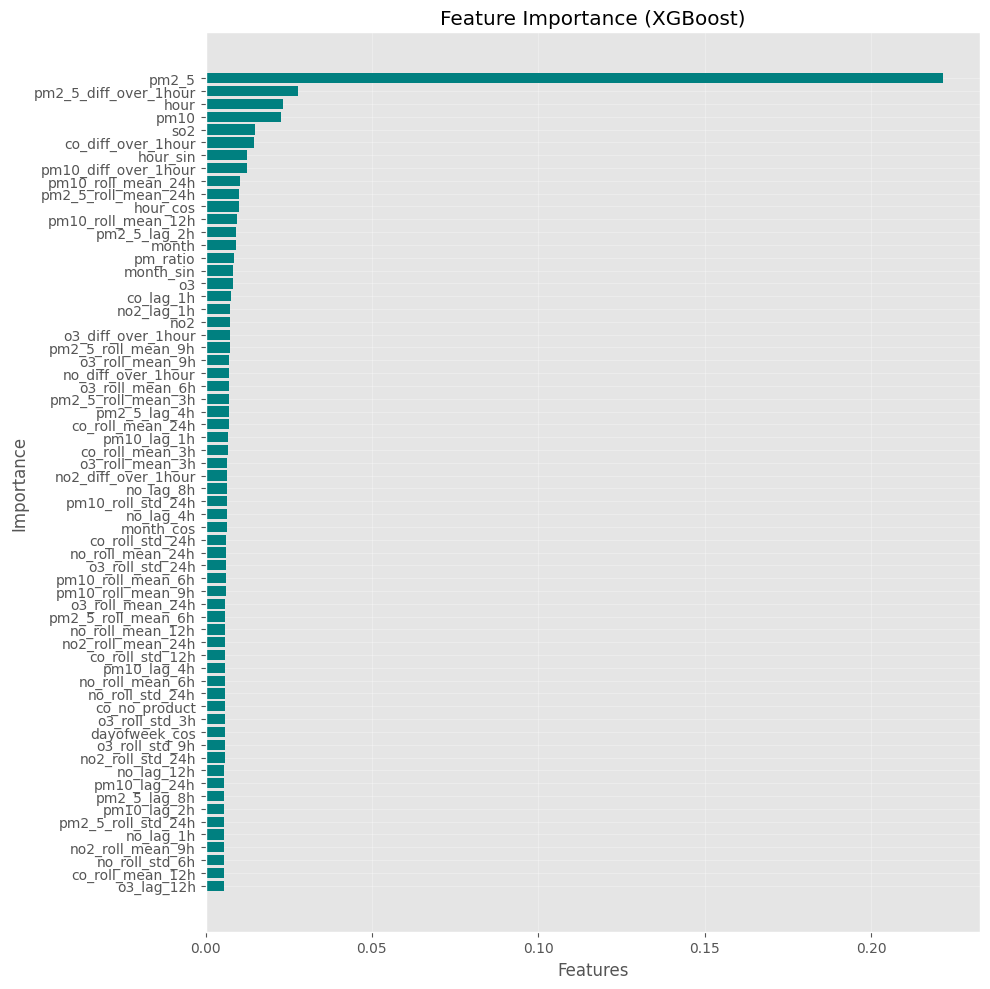

In [13]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

features = np.array(X.columns)
top_n = 64
top_features = features[sorted_idx][:top_n]
top_importance = importance[sorted_idx][:top_n]

# Vẽ barplot
plt.figure(figsize=(10,10))
plt.barh(top_features[::-1], top_importance[::-1], color='teal')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import joblib

joblib.dump(model, "aqi_model.pkl")
feature_list = list(X.columns)
joblib.dump(feature_list, "features.pkl")
print('Model with ', len(feature_list), 'features exported:\n')
print(feature_list)

print(f"Model feature exported")

Model with  122 features exported:

['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'co_lag_1h', 'co_lag_2h', 'co_lag_4h', 'co_lag_8h', 'co_lag_12h', 'co_lag_24h', 'co_roll_mean_3h', 'co_roll_std_3h', 'co_roll_mean_6h', 'co_roll_std_6h', 'co_roll_mean_9h', 'co_roll_std_9h', 'co_roll_mean_12h', 'co_roll_std_12h', 'co_roll_mean_24h', 'co_roll_std_24h', 'co_diff_over_1hour', 'no2_lag_1h', 'no2_lag_2h', 'no2_lag_4h', 'no2_lag_8h', 'no2_lag_12h', 'no2_lag_24h', 'no2_roll_mean_3h', 'no2_roll_std_3h', 'no2_roll_mean_6h', 'no2_roll_std_6h', 'no2_roll_mean_9h', 'no2_roll_std_9h', 'no2_roll_mean_12h', 'no2_roll_std_12h', 'no2_roll_mean_24h', 'no2_roll_std_24h', 'no2_diff_over_1hour', 'pm2_5_lag_1h', 'pm2_5_lag_2h', 'pm2_5_lag_4h', 'pm2_5_lag_8h', 'pm2_5_lag_12h', 'pm2_5_lag_24h', 'pm2_5_roll_mean_3h', 'pm2_5_roll_std_3h', 'pm2_5_roll_mean_6h', 'pm2_5_roll_std_6h', 'pm2_5_rol